# Libraries

In [1]:
import sys

sys.path.append("../")

import pandas as pd
import numpy as np
from src.preprocessing import load_data
from sklearn.decomposition import PCA

from src.models import DistanceBasedClassifier
from sklearn.neighbors import KNeighborsClassifier
from main import FaceRecognitionModel

from src.model_selection import cross_validation
from sklearn.model_selection import StratifiedKFold

from src.visualization import cumulative_variance_ratio_plot, pca_scree_plot
from src.visualization import knn_visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("Set2")

# Load Data

In [2]:
images, labels = load_data(path="../att-data/s{}/{}.pgm")

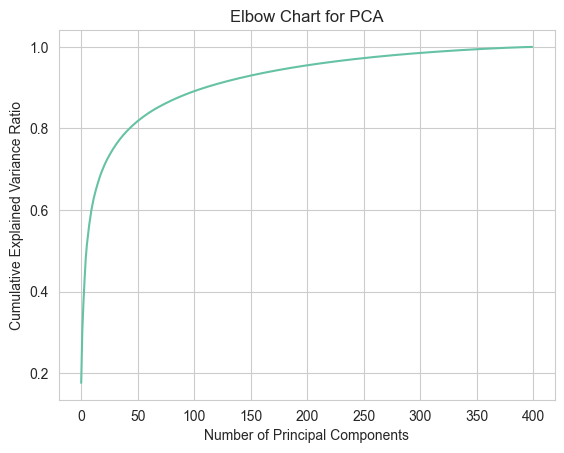

In [3]:
cumulative_variance_ratio_plot(images)

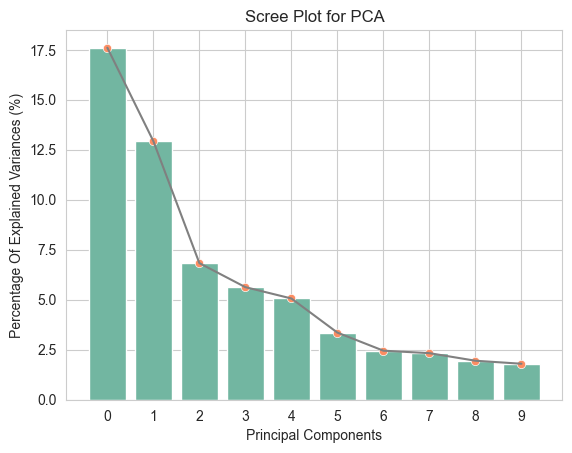

In [4]:
pca_scree_plot(images)

__COMMENTS__
<br>
The optimal number of Principle Components should be under 100 to satisfy those two conditions simultaneously:
* Retain as much as possible the variance of the whole dataset
* Avoid overfitting

In [5]:
distance_methods = {'euclidean': DistanceBasedClassifier(method="euclidean"),
                    'manhattan': DistanceBasedClassifier(method="manhattan", method_type="normal"),
                    'weighted manhattan': DistanceBasedClassifier(method="manhattan", method_type="weighted"),
                    'modified manhattan': DistanceBasedClassifier(method="manhattan", method_type="modified"),
                    'weighted modified manhattan': DistanceBasedClassifier(method="manhattan", method_type="weighted-modified"),
                    'angle-based': DistanceBasedClassifier(method="angle", method_type="normal"),
                    'weighted angle-based': DistanceBasedClassifier(method="angle", method_type="weighted"),
                    'correlation coefficient-based': DistanceBasedClassifier(method="correlation-coefficient"),
                    'mahalanobis': DistanceBasedClassifier(method="mahalanobis", method_type="normal"),
                    'mahalanobis normed vectors': DistanceBasedClassifier(method="mahalanobis", method_type="normal", normed_vector="True"),
                    'canberra': DistanceBasedClassifier(method="canberra"),
                    'chi-square': DistanceBasedClassifier(method="chi-square")}

# Testing

In [6]:
import time
t0 = time.time()

try:
    distance_test_df = pd.read_csv("../output/csv/distance_test.csv", index_col=0)
    distance_test_df.columns = [int(i) for i in distance_test_df.columns]
except:
    n_components = np.arange(10, 101, 10)
    distance_test = {'methods': []}

    for i in n_components:
        distance_test[i] = []

    for method, classifier in distance_methods.items():
        distance_test['methods'].append(method)
        t1 = time.time()
        for n in n_components:
            model = FaceRecognitionModel(preprocessor=PCA(n_components=n, svd_solver="full"),
                                         classifier=classifier)
            scores = cross_validation(estimator=model, X=images, y=labels, cv=5, random_state=42)
            distance_test[n].append(scores.mean())
        print("{}: {}".format(method, time.time()-t1))
    distance_test_df = pd.DataFrame(distance_test)
    distance_test_df = distance_test_df.set_index(distance_test_df.columns[0])
    distance_test_df.to_csv("../output/csv/distance_test.csv")
    print('Done in: {}'.format(time.time()-t0))

In [7]:
distance_test_df

,10,20,30,40,50,60,70,80,90,100
methods,,,,,,,,,,
euclidean,0.9425,0.9575,0.9750,0.9675,0.9750,0.9725,0.9725,0.9700,0.9725,0.9725
manhattan,0.9425,0.9525,0.9650,0.9700,0.9700,0.9600,0.9625,0.9550,0.9525,0.9550
weighted manhattan,0.9275,0.9350,0.9525,0.9400,0.9275,0.9275,0.9125,0.9050,0.8975,0.8950
modified manhattan,0.9225,0.9600,0.9575,0.9650,0.9600,0.9575,0.9500,0.9625,0.9600,0.9625
weighted modified manhattan,0.9100,0.9375,0.9550,0.9400,0.9225,0.9200,0.9100,0.9150,0.9050,0.9075
angle-based,0.9500,0.9575,0.9725,0.9725,0.9725,0.9700,0.9700,0.9725,0.9700,0.9725
weighted angle-based,0.9225,0.9450,0.9650,0.9675,0.9700,0.9675,0.9600,0.9600,0.9625,0.9600
correlation coefficient-based,0.9300,0.9550,0.9650,0.9700,0.9725,0.9675,0.9675,0.9700,0.9700,0.9700
mahalanobis,0.9275,0.9425,0.9475,0.9375,0.9300,0.9175,0.9075,0.9000,0.8900,0.8775


# Result Visualization

### Overall

Text(50.7222222222222, 0.5, 'Distance Metrics')

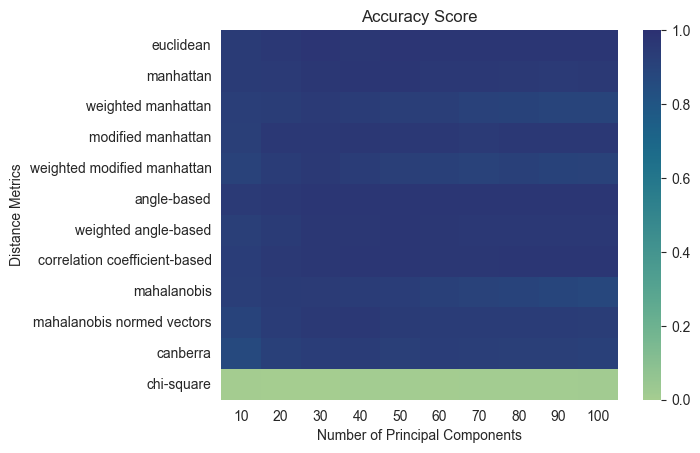

In [8]:
sns.heatmap(distance_test_df, vmin=0, vmax=1, cmap="crest")
plt.xlabel("Number of Principal Components")
plt.title("Accuracy Score")
plt.ylabel("Distance Metrics")

__COMMENT__
<br>
The almost monochromatic heatmap demonstrates consistent results from various distance metrics (except for chi-square), with accuracy scores of approximately 0.9 or higher.

### Performance Of N-components

In [9]:
# average accuracy score of each component
avg_acc_pca = distance_test_df.mean(axis=0)
avg_acc_pca.sort_values(ascending=False)

30     0.878750
40     0.878125
50     0.873125
60     0.869792
20     0.866667
70     0.865833
80     0.865208
90     0.862708
100    0.861458
10     0.845625
dtype: float64

In [10]:
# maximum accuracy score of each component
max_acc_pca = distance_test_df.max(axis=0)
max_acc_pca.sort_values(ascending=False)

30     0.9750
50     0.9750
40     0.9725
60     0.9725
70     0.9725
80     0.9725
90     0.9725
100    0.9725
20     0.9600
10     0.9500
dtype: float64

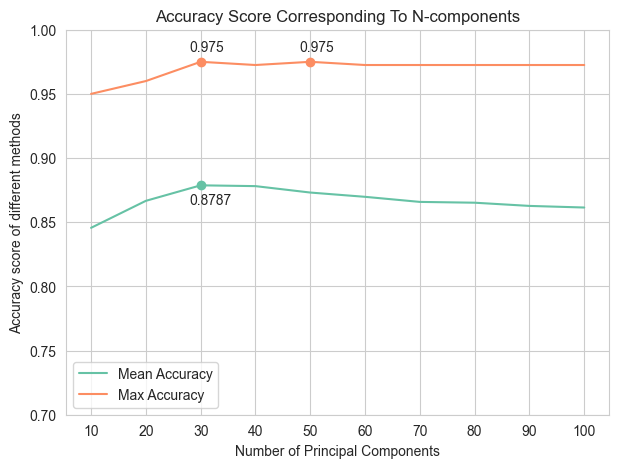

In [11]:
# colors = ['#011a4b', '#3e5277', '#69a0d7', '#9acedd', '#c9b67b', '#3e4752', '#e7edf3']

plt.figure(figsize=(7, 5))

avg_line = sns.lineplot(avg_acc_pca, label="Mean Accuracy", linestyle='-')
avg_line = avg_line.get_lines()[0]
avg_acc_pca_index = avg_acc_pca[avg_acc_pca==avg_acc_pca.max()].index
for i in range(len(avg_acc_pca_index)):
    plt.scatter(x=avg_acc_pca_index[i], y=avg_acc_pca.max(), color=avg_line.get_color())
    plt.annotate(text=round(avg_acc_pca.max(), 4), xy=(avg_acc_pca_index[i]-2, avg_acc_pca.max()-0.015))

max_line = sns.lineplot(max_acc_pca, linestyle="-", label="Max Accuracy")
max_line = max_line.get_lines()[1]
max_acc_pca_index = max_acc_pca[max_acc_pca==max_acc_pca.max()].index
for i in range(len(max_acc_pca_index)):
    plt.scatter(x=max_acc_pca_index[i], y=max_acc_pca.max(), color=max_line.get_color())
    plt.annotate(text=round(max_acc_pca.max(), 4), xy=(max_acc_pca_index[i]-2, max_acc_pca.max()+0.008))

ymin = np.min([avg_acc_pca, max_acc_pca])
plt.ylim(0.7, 1)
plt.legend()

plt.xlabel("Number of Principal Components")
plt.ylabel("Accuracy score of different methods")
plt.title("Accuracy Score Corresponding To N-components")
plt.xticks(range(10, 101, 10))
plt.legend()

plt.grid(True)

### Top distance metrics within dataset

In [12]:
distance_test_df_truncate = distance_test_df.iloc[:, 2:5].copy()
distance_test_df_truncate["max"] = distance_test_df_truncate.max(axis=1)
distance_test_df_truncate["mean"] = distance_test_df_truncate.mean(axis=1)
distance_test_df_truncate.sort_values(by=["max", "mean"], ascending=False)

,30,40,50,max,mean
methods,,,,,
euclidean,0.9750,0.9675,0.9750,0.9750,0.973125
angle-based,0.9725,0.9725,0.9725,0.9725,0.972500
correlation coefficient-based,0.9650,0.9700,0.9725,0.9725,0.970000
manhattan,0.9650,0.9700,0.9700,0.9700,0.968750
weighted angle-based,0.9650,0.9675,0.9700,0.9700,0.968125
modified manhattan,0.9575,0.9650,0.9600,0.9650,0.961875
mahalanobis normed vectors,0.9550,0.9600,0.9425,0.9600,0.954375
weighted modified manhattan,0.9550,0.9400,0.9225,0.9550,0.943125
weighted manhattan,0.9525,0.9400,0.9275,0.9525,0.943125


In [13]:
distance_test_df_top = distance_test_df_truncate.sort_values(by=["max", "mean"], ascending=False).head(3)
distance_test_df_top

,30,40,50,max,mean
methods,,,,,
euclidean,0.9750,0.9675,0.9750,0.9750,0.973125
angle-based,0.9725,0.9725,0.9725,0.9725,0.972500
correlation coefficient-based,0.9650,0.9700,0.9725,0.9725,0.970000


In [14]:
print("Top 3 distance based methods:", ", ".join(distance_test_df_top.index.values))

Top 3 distance based methods: euclidean, angle-based, correlation coefficient-based


__COMMENTS__
<br>
* Top 3 distance based methods seem to be euclidean, mse, angle-based
* Chi square distance seems to have the worst performance (accuracy score is under 0.1) due to some reason
    * Chi square distance requires non-negative values while the dataset contains negative values
    * ...

In [15]:
distance_test_df_top = distance_test_df.loc[distance_test_df_top.index]
distance_test_df_top

,10,20,30,40,50,60,70,80,90,100
methods,,,,,,,,,,
euclidean,0.9425,0.9575,0.9750,0.9675,0.9750,0.9725,0.9725,0.9700,0.9725,0.9725
angle-based,0.9500,0.9575,0.9725,0.9725,0.9725,0.9700,0.9700,0.9725,0.9700,0.9725
correlation coefficient-based,0.9300,0.9550,0.9650,0.9700,0.9725,0.9675,0.9675,0.9700,0.9700,0.9700


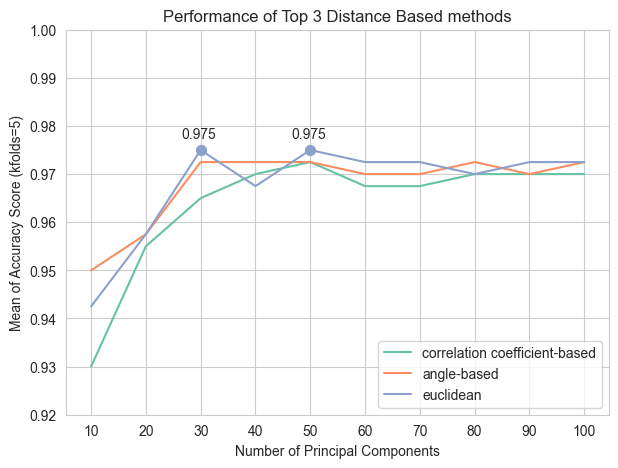

In [16]:
fig, ax = plt.subplots(figsize=(7, 5))

colors = ['#69a0d7', '#c9b67b', '#3e4752']

max_accuracy = distance_test_df_truncate.iloc[:, :3].max().max()
max_index = distance_test_df_top[distance_test_df_top==max_accuracy].stack().index

for method in distance_test_df_top.index[-1::-1]:
    ax.plot(np.arange(10, 101, 10), distance_test_df_top.loc[method], label=method,
            linestyle='-', linewidth=1.5, markersize=3.6, alpha=1)
    
max_color = ax.get_lines()[-1].get_color()

for i in range(len(max_index)):
    plt.scatter(x=int(max_index[i][1]), y=max_accuracy, s=50, color=max_color)
    plt.annotate(text=round(max_accuracy, 5), xy=(max_index[i][1]-3.5, max_accuracy+0.0025))
    
ymin = np.min(distance_test_df_top)
ax.set_ylim(round(ymin, 2)-0.01, 1)
ax.legend(loc='lower right')
ax.set_title("Performance of Top 3 Distance Based methods")
ax.set_xlabel("Number of Principal Components")
ax.set_ylabel("Mean of Accuracy Score (kfolds=5)")
ax.set_xticks(range(10, 101, 10))
plt.grid(True)

### Misclassification
Misclassification of euclidean method and 50 components (having highest accuracy score)

Fold 0 - Accuracy: 0.9875
Fold 1 - Accuracy: 0.9625
Fold 2 - Accuracy: 0.9875
Fold 3 - Accuracy: 0.9875
Fold 4 - Accuracy: 0.95


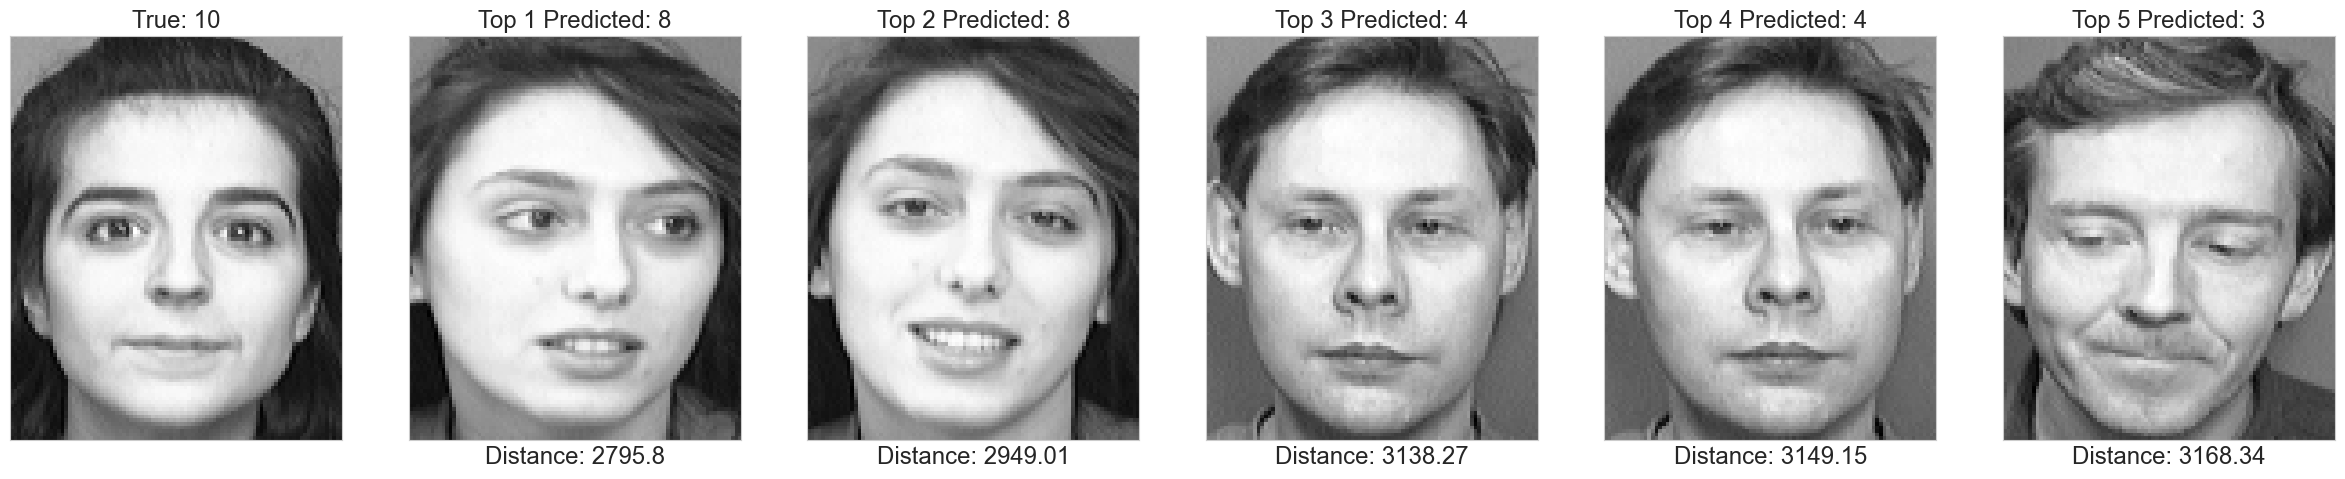

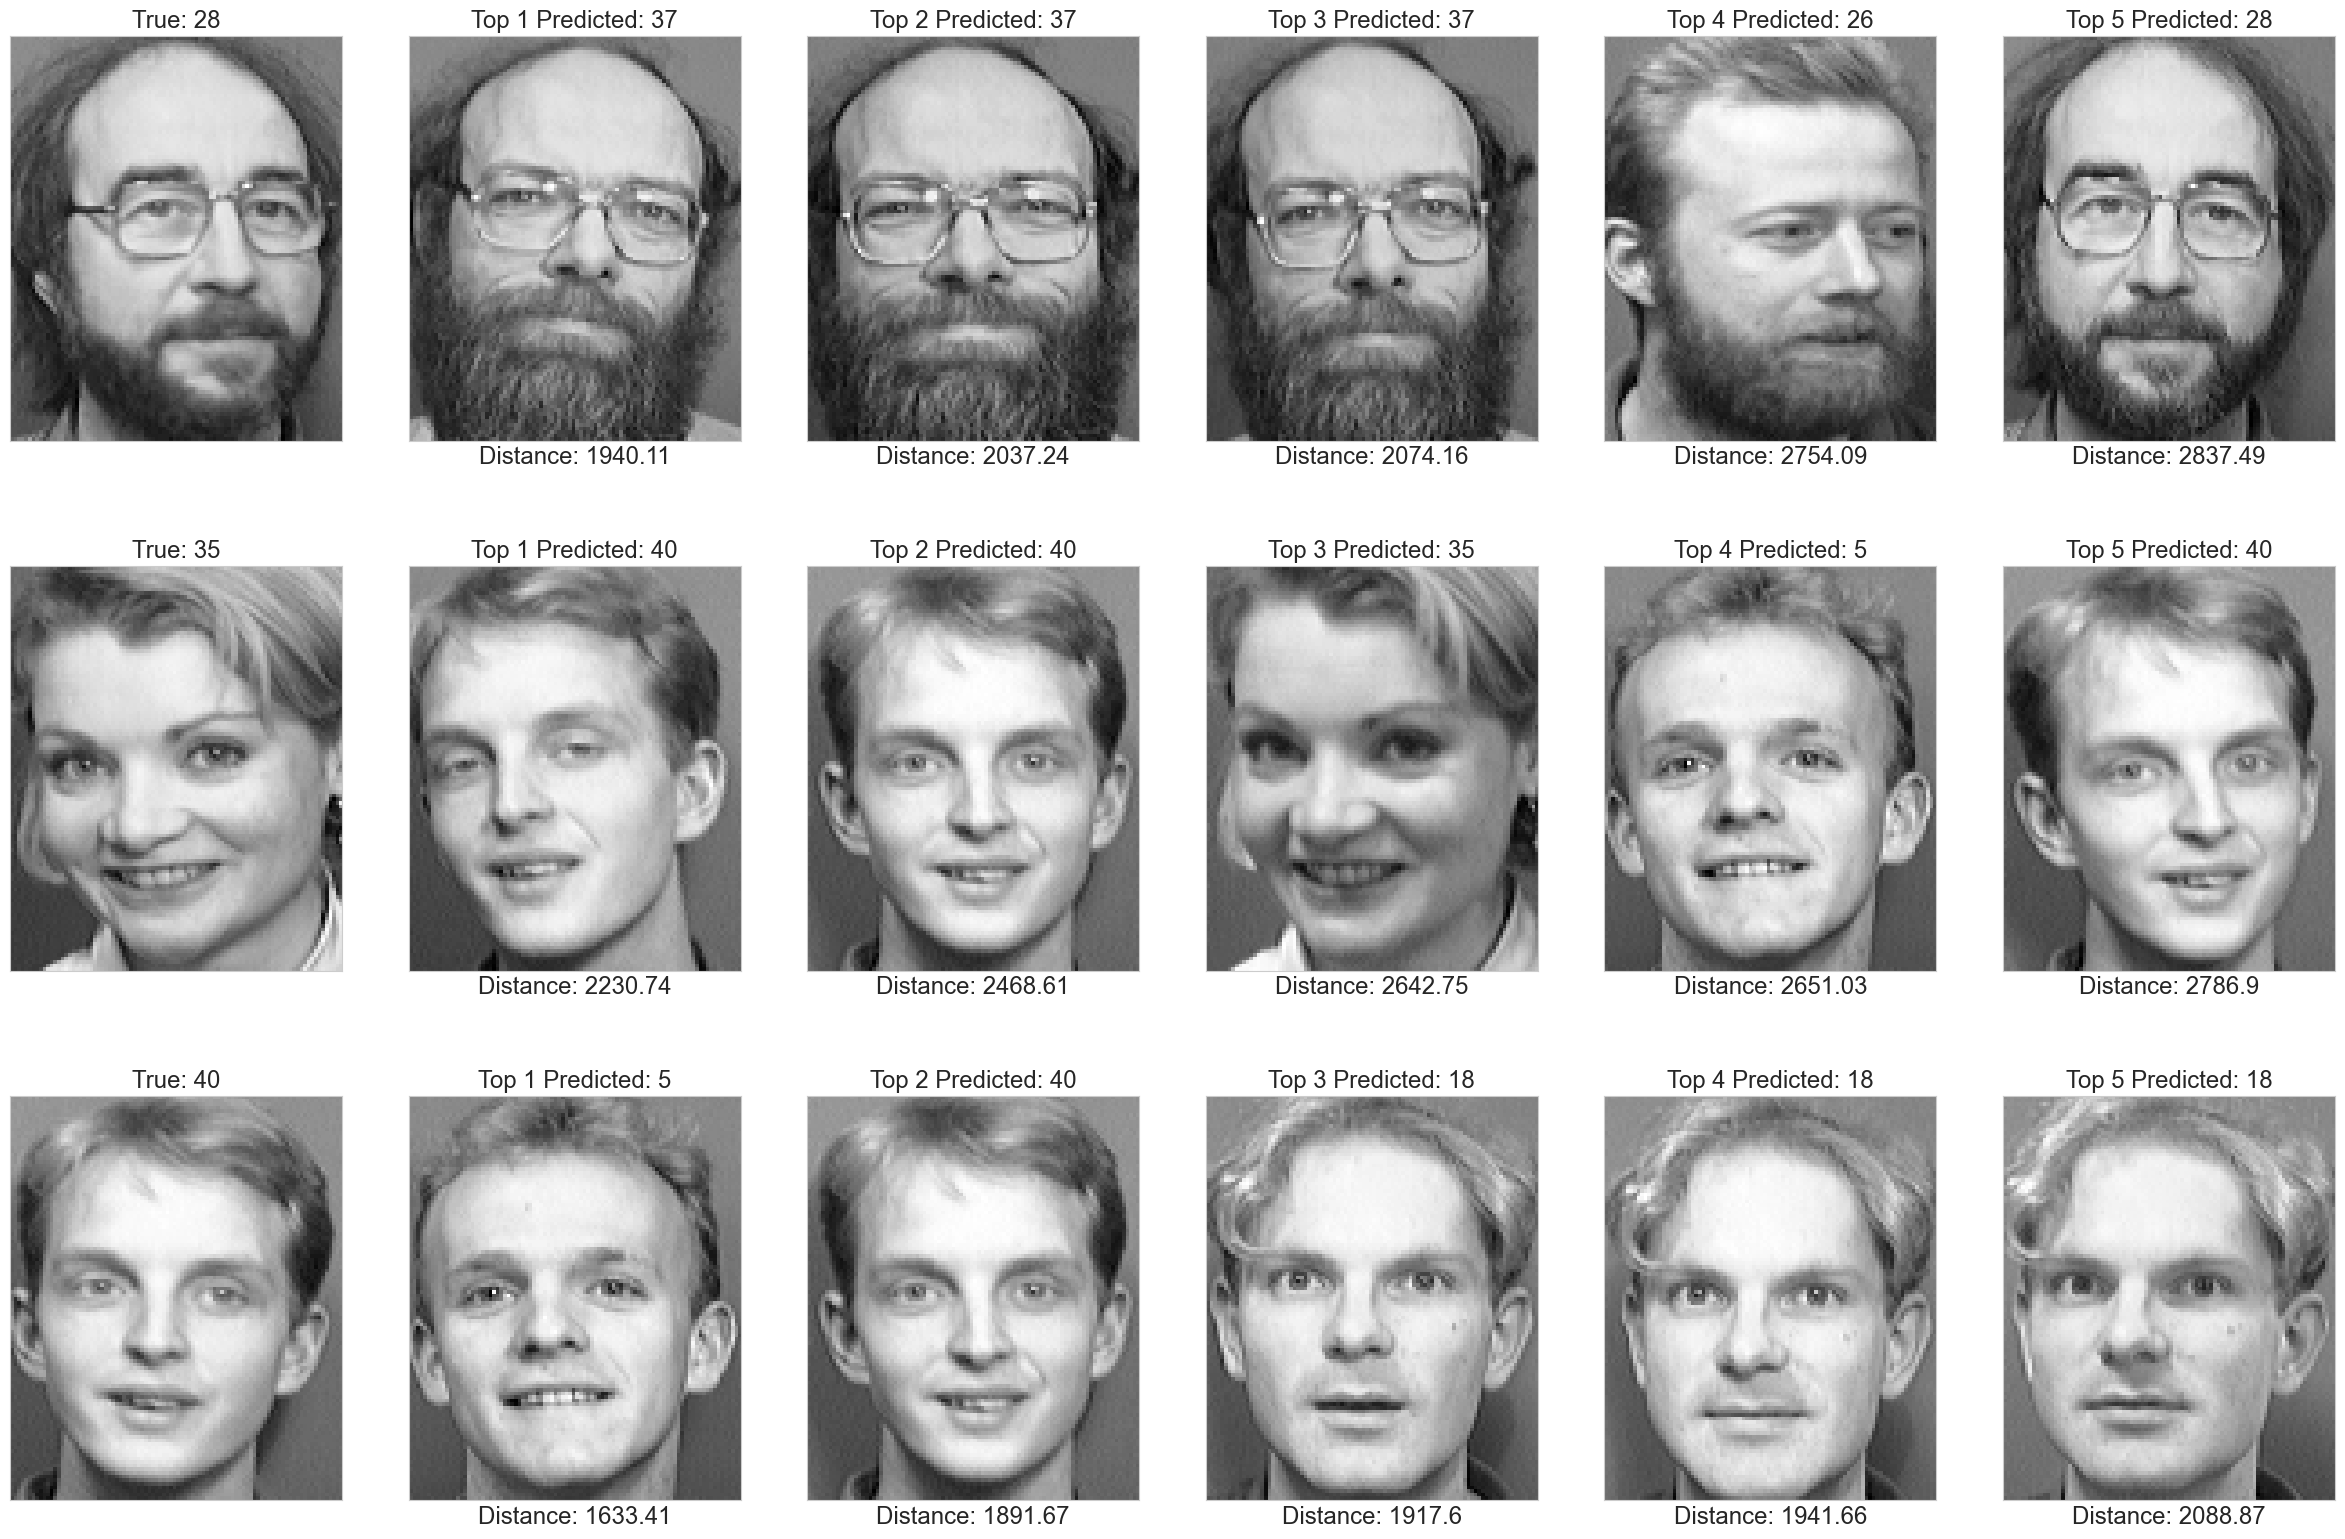

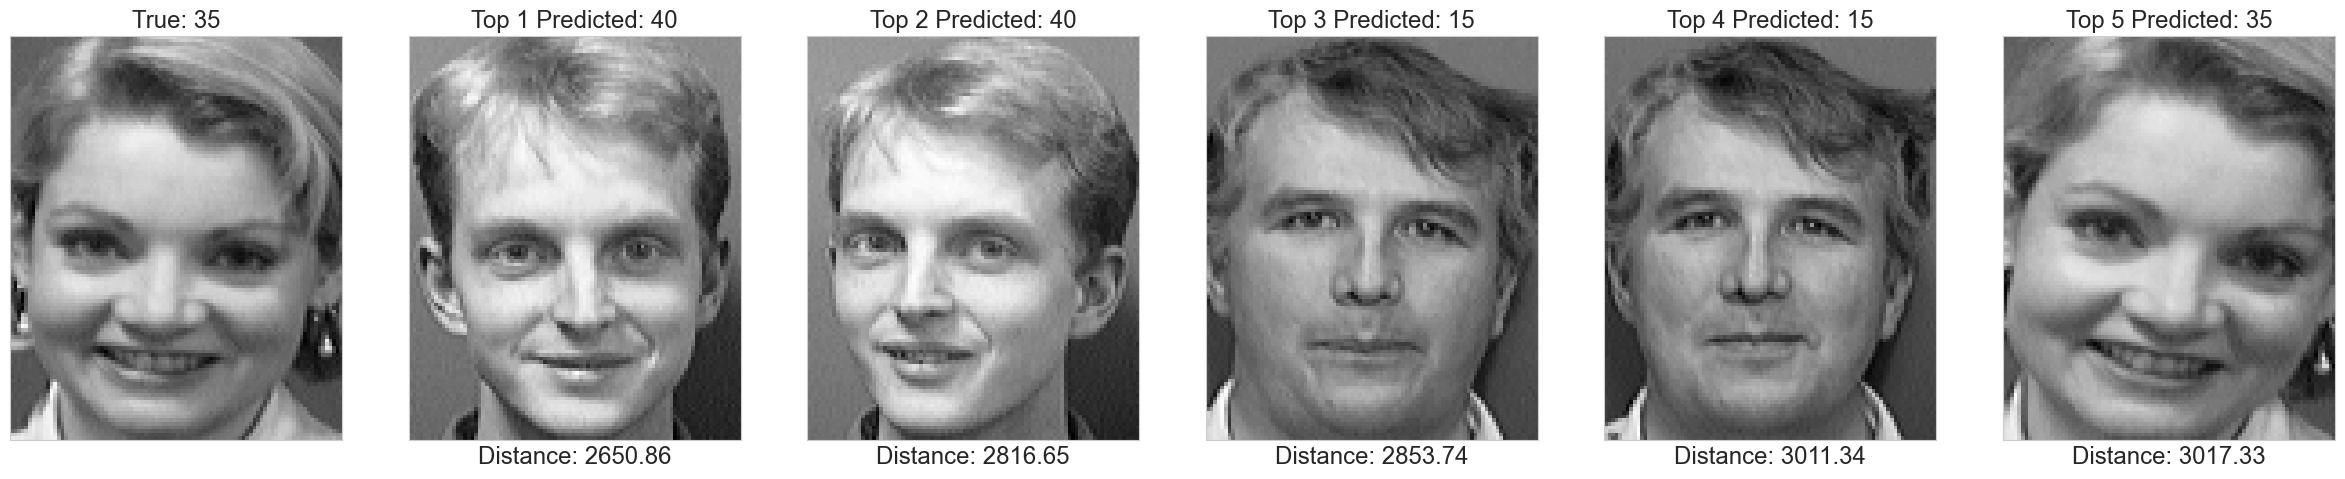

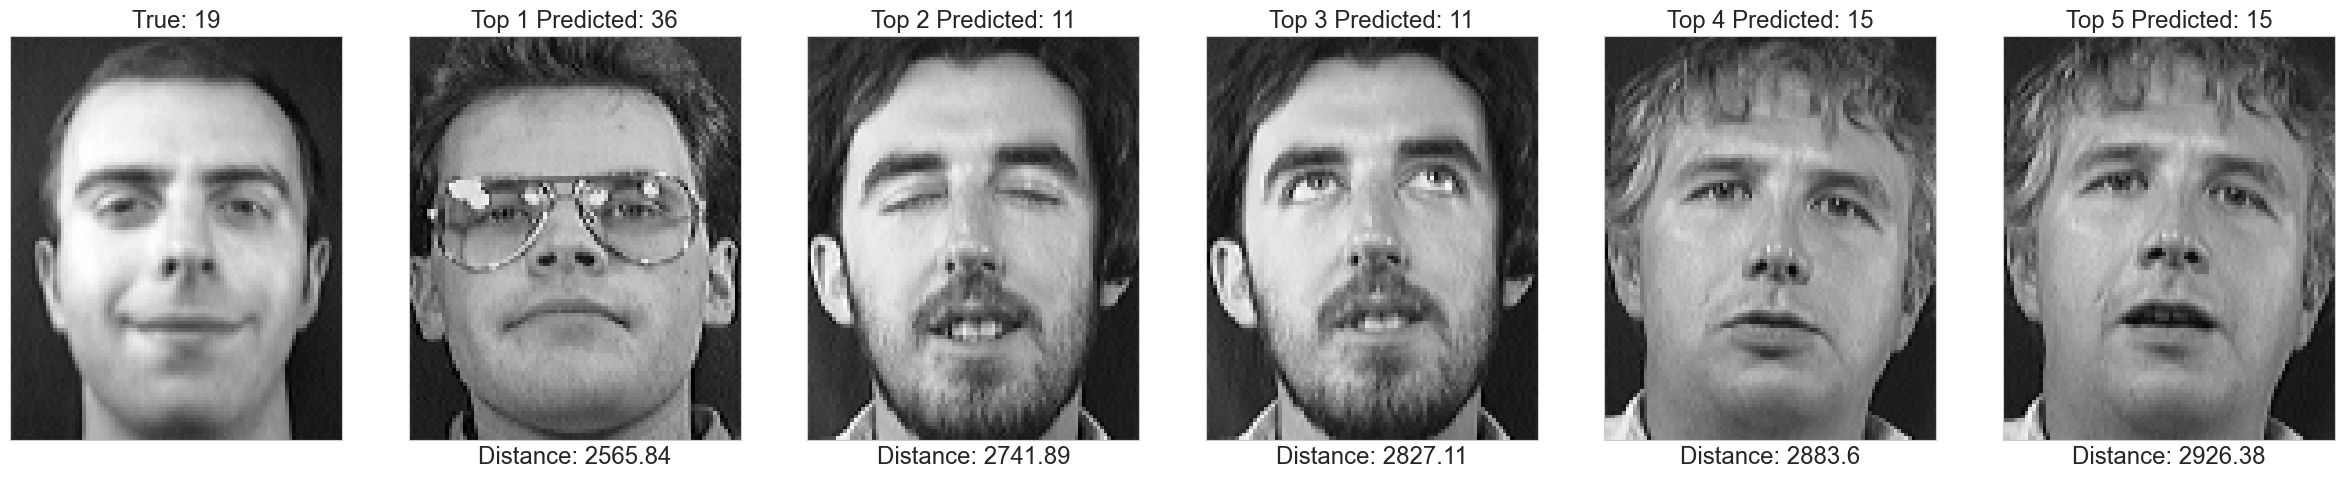

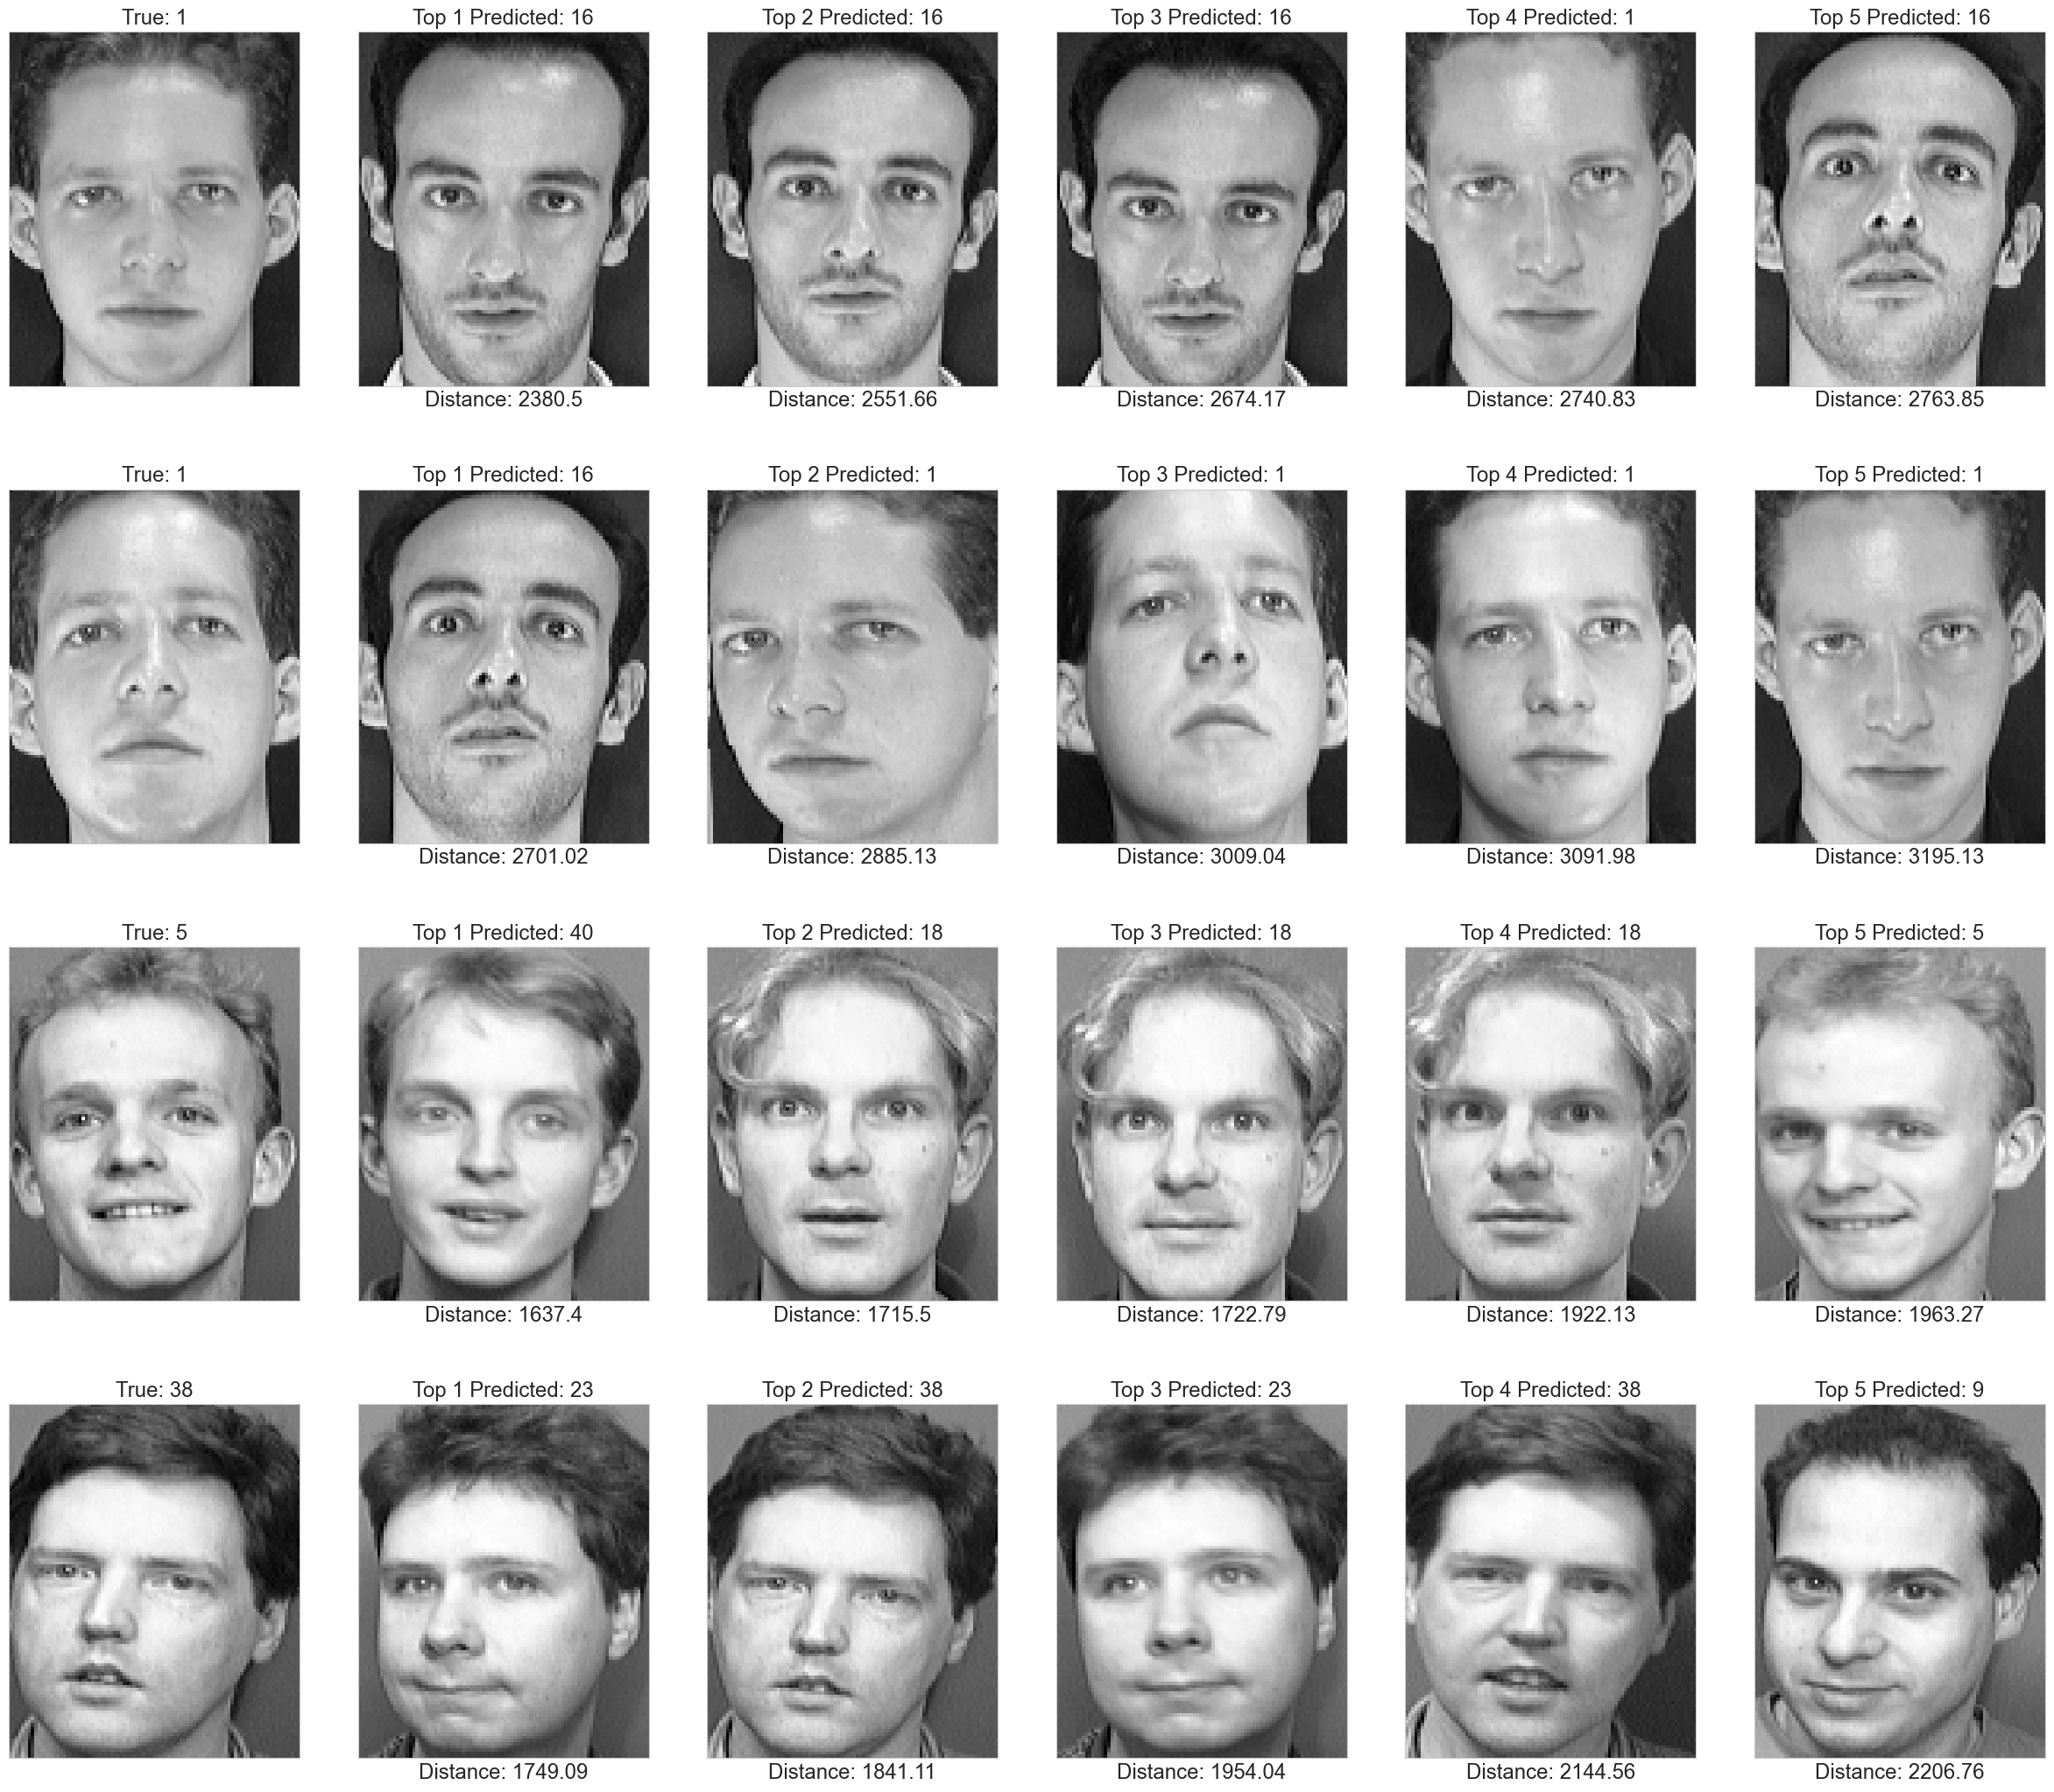

In [20]:
images, labels = load_data(path="../att-data/s{}/{}.pgm")
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for i, (train_index, test_index) in enumerate(kfolds.split(images, labels)):
    print(f"Fold {i} -", end=' ')
    model = FaceRecognitionModel(preprocessor=PCA(n_components=30, svd_solver="full"),
                                 classifier=KNeighborsClassifier(metric='l2', n_neighbors=1))
    x_train, y_train = images[train_index], labels[train_index]
    x_test, y_test = images[test_index], labels[test_index]
    knn_visualization(x_train, y_train, x_test, y_test, model=model, k_neighbors=5,
                      show_distance=True, wrong_case_only=True, indices=None, reconstruct_image=False)


__COMMENTS__
<br>
Most of the neighbors closest to misclassified cases have the same facial angle when the photos were taken and look slightly identical when viewed as a whole without focusing on certain features.